# Budyko Curves

[Moine et al 2007](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2006WR005608)
- leaking/gaining topographic catchments will be called non- conservative (NC)
- Can RR models deal with such local groundwater drainage systems, possibly identify them, and perhaps even quantify the associated intercatchment groundwater flow?
- Catchments are systems with too many unknowns for too few equations, where measurable inputs (precipita- tion) and measurable outputs (streamflow) are known with uncertainty, while two sources of output fluxes (an upward evaporation flux and a downward ‘‘leakage’’ flux) are mostly unobservable.
- However, even when the catchment is an obvious outlier, this does not help us to guess what type of physical fluxes the discharge deficit represents. Is evapotranspiration and/or precipitation underestimated or overestimated? Has the topographic catchment been wrongly delimited? Is it leaking?

In [2]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [4]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [5]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [6]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [7]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read Predictions

In [ ]:
from scripts.drafts.io_results import read_ensemble_results, read_fuse_data
from scripts.drafts.delta_error import DeltaError
SAVE = True
RELOAD = False

if RELOAD:
    pet_ealstm_ensemble_dir = data_dir / "runs/ensemble_pet_ealstm"
    ealstm_preds = read_ensemble_results(pet_ealstm_ensemble_dir)

    lstm_ensemble_dir = data_dir / "runs/ensemble_pet"
    lstm_preds = read_ensemble_results(lstm_ensemble_dir)

    raw_fuse_path = data_dir / "RUNOFF/FUSE"
    fuse_data = read_fuse_data(raw_fuse_path, lstm_preds["obs"])

    # get matching stations
    all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
    all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)
    lstm_preds = lstm_preds.sel(
        station_id=all_stations_lstm, time=np.isin(lstm_preds.time, fuse_data.time)
    )
    ealstm_preds = ealstm_preds.sel(
        station_id=all_stations_ealstm, time=np.isin(ealstm_preds.time, fuse_data.time)
    )

    all_preds = xr.open_dataset(data_dir / "RUNOFF/all_preds.nc")
    all_preds = processor.all_preds
    
    if SAVE:
        all_preds.to_netcdf(data_dir / "RUNOFF/all_preds.nc")

else:
    all_preds = xr.open_dataset(data_dir / "RUNOFF/all_preds.nc")


# Read Errors/Metrics

In [9]:
import pickle
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict

RELOAD = False

if RELOAD:
    all_errors = calculate_all_data_errors(all_preds, decompose_kge=True)
    all_metrics = get_metric_dataframes_from_output_dict(all_errors)
    if SAVE:
        pickle.dump(all_errors, (data_dir / "RUNOFF/all_errors.pkl").open("wb"))
        pickle.dump(all_metrics, (data_dir / "RUNOFF/all_metrics.pkl").open("wb"))
    
else:
    all_errors = pickle.load((data_dir / "RUNOFF/all_errors.pkl").open("rb"))
    all_metrics = pickle.load((data_dir / "RUNOFF/all_metrics.pkl").open("rb"))
    
all_metrics.keys()

# all_metrics.keys()

dict_keys(['nse', 'kge', 'mse', 'bias', 'pbias', 'log_nse', 'inv_kge', 'sqrt_kge', 'abs_pct_bias', 'mape', 'bias_error', 'std_error', 'fms', 'flv', 'fhv', 'mam30_ape', 'rmse', 'correlation', 'bias_ratio', 'variability_ratio', 'inv_correlation', 'inv_bias_ratio', 'inv_variability_ratio', 'sqrt_correlation', 'sqrt_bias_ratio', 'sqrt_variability_ratio'])

# Read Delta Errors

In [10]:
from scripts.drafts.calculate_error_scores import calculate_all_delta_dfs

lstm_delta, ealstm_delta = calculate_all_delta_dfs(
    all_metrics,
    absolute_metrics=[
            "fms",
            "flv",
            "fhv",
            "bias_error",
            "bias_error_pct",
            "std_error",
            "std_error_pct",
        ],
)

# Plot Budyko

In [11]:
def assign_wateryear(dt):
    """https://stackoverflow.com/a/52615358/9940782"""
    dt = pd.Timestamp(dt)
    if dt.month >= 10:
        return(pd.datetime(dt.year+1,1,1).year)
    else:
        return(pd.datetime(dt.year,1,1).year)

In [12]:
curve = lambda x: 1 - (1/x)
wetness_ix = lambda p, pe: p/pe
runoff_coeff = lambda p, q: q/p

In [13]:
# ds[["precipitation", "discharge_spec", "pet"]]
ds_wy = ds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in ds.time.values]))
ds_wy_sum = ds_wy.groupby("wy").sum().isel(wy=slice(1, -1))
# ds_wy_sum["precipitation"]; ds_wy_sum["discharge_spec"]; ds_wy_sum["pet"]

def calculate_curve_params(ds: xr.Dataset):
    x = wetness_ix(ds["precipitation"], ds["pet"])
    y = runoff_coeff(ds["precipitation"], ds["discharge_spec"])
    
    return x, y

_ds = ds_wy_sum.sel(station_id=all_metrics["nse"]["LSTM"].index).mean(dim="wy")
x, y = calculate_curve_params(ds=_ds)

_ds = ds.sel(station_id=all_metrics["nse"]["LSTM"].index).mean(dim="time")
x, y = calculate_curve_params(ds=_ds)

In [14]:
# ds.sel(station_id=all_preds.station_id).mean(dim="time")

In [15]:
# x = x.sel(station_id=all_metrics["nse"]["LSTM"].index)
# y = y.sel(station_id=all_metrics["nse"]["LSTM"].index)

In [16]:
# color_var.quantile(q=0.15)

In [17]:
from typing import Optional, List, Dict, Tuple

def _add_annotations(ax):
    ax.text(8, 0.1, "Runoff Deficits\nExceed Total PET", size=10, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )
    
    ax.text(5, 1.4, "Runoff Exceeds Rainfall Inputs", size=10, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )
    return ax


def plot_budyko_curve(
    ds: xr.Dataset,
    color_var: Optional[np.ndarray] = None, 
    color_label: str = "",
    ax=None, scale: float = 1.2,
    vmin: Optional[float] = None, vmax: Optional[float] = None,
    annotate: bool = True, colorbar: bool = True,
    scatter_kwargs: Dict = {"alpha": 0.7}
):
    # 1. calculate wetness index (x) and runoff coefficient (y)
    assert all(np.isin(["precipitation", "pet", "discharge_spec"], ds.data_vars))
    x, y = calculate_curve_params(ds=ds)

    if ax == None:
        _, ax = plt.subplots(figsize=(6*scale,4*scale))
    
    # set colors
    if color_var is not None:
        if vmin is None:
            vmin = color_var.quantile(q=0.15)
        if vmax is None:
            vmax = color_var.quantile(q=0.85)

    # 2. create the scatter plot
    sc = ax.scatter(x, y, c=color_var, vmin=vmin, vmax=vmax, **scatter_kwargs)
    if (color_var is not None) and colorbar:
        cbar = plt.colorbar(sc)
        cbar.ax.set_ylabel(color_label)
    
    # 3. create the reference lines
    # horizontal line
    ax.axhline(1, color="grey", ls="--")
    # curve
    c = curve(np.linspace(1e-1, ax.get_xlim()[-1]+1))
    ax.plot(np.linspace(1e-1, ax.get_xlim()[-1]+1), c, color="grey", ls="-.")
    
    # 4. beautify the plot
    if annotate:
        ax = _add_annotations(ax)
        
    ax.set_ylim(0, 1.5)
    ax.set_xlim(0, 9)
    ax.set_xlabel("Wetness Index (P/PE)")
    ax.set_ylabel("Runoff Coefficient (Q/P)")
    sns.despine()
    
    return ax

In [18]:
_ds = ds_wy_sum.sel(station_id=all_metrics["nse"]["LSTM"].index).mean(dim="wy")
_ds = ds.sel(station_id=all_metrics["nse"]["LSTM"].index).mean(dim="time")

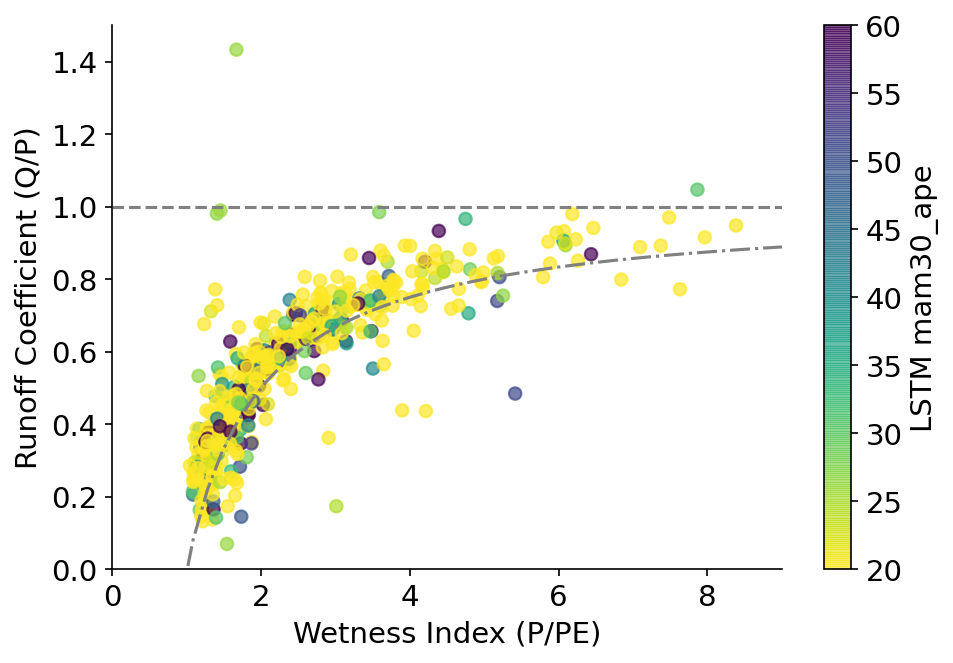

In [19]:
color_var = all_metrics["mam30_ape"]["LSTM"]

ax=None
plot_budyko_curve(
    ds=_ds, color_var=color_var, color_label="LSTM mam30_ape",
    vmin=20, vmax=60, scatter_kwargs={"cmap": "viridis_r", "alpha": 0.7},
    ax=ax, annotate=False
)

ValueError: index 6 is out of bounds for array with size 6

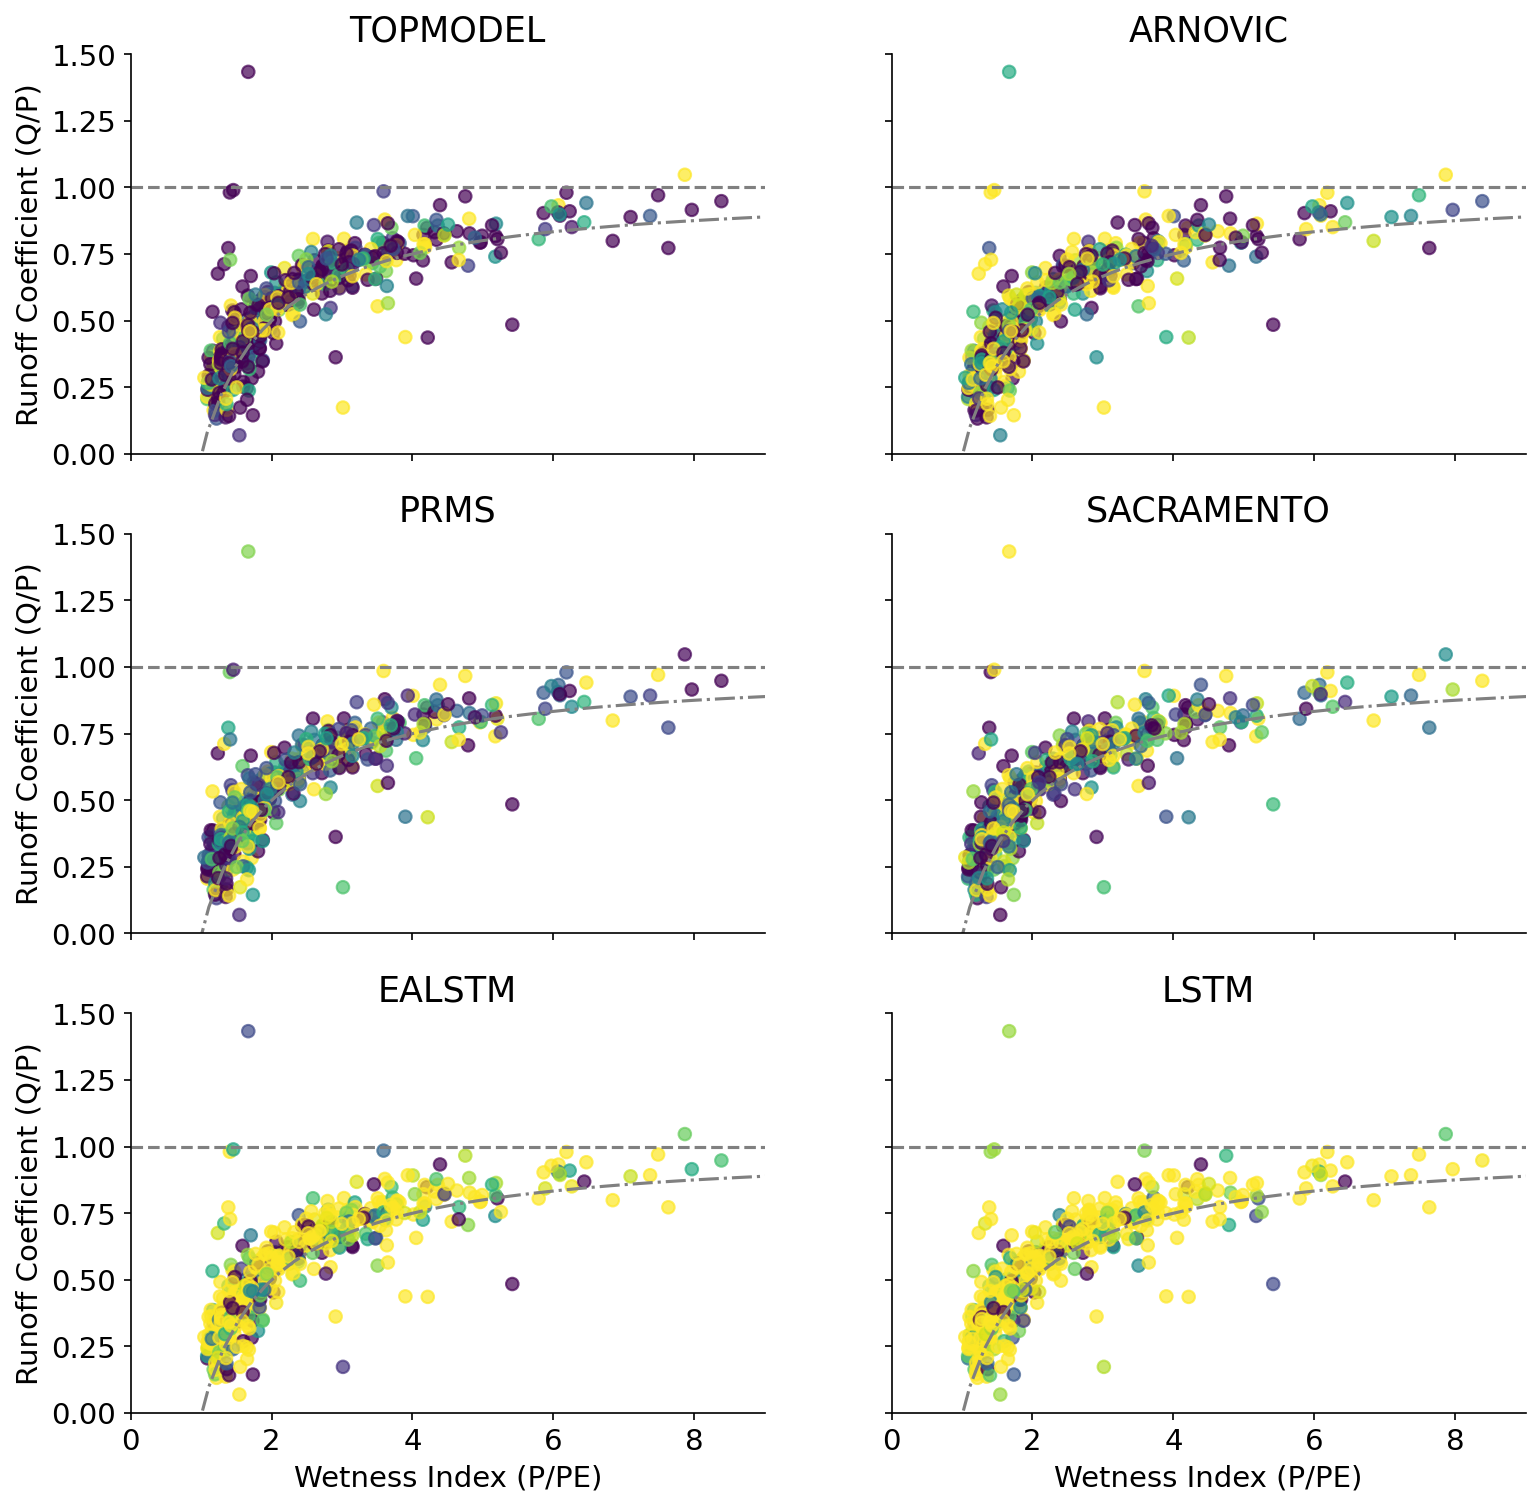

In [20]:
metric = "mam30_ape"


scale = 1
f, axs = plt.subplots(3, 2, figsize=(6*scale*2, 4*scale*3), sharex=True, sharey=True)

for ix, model in enumerate(all_metrics[metric].columns):
    ax = axs[np.unravel_index(ix, (3, 2))]
    color_var = all_metrics[metric][model]
    plot_budyko_curve(
        ds=_ds, color_var=color_var, color_label="Sacramento mam30_ape",
        vmin=20, vmax=60, scatter_kwargs={"cmap": "viridis_r", "alpha": 0.7},
        ax=ax, annotate=False, colorbar=False
    )
    if np.unravel_index(ix, (3, 2))[0] != 2:
        ax.set_xlabel("")
    if np.unravel_index(ix, (3, 2))[1] != 0:
        ax.set_ylabel("")
        
    ax.set_title(model)

In [ ]:
all_metrics["mam30_ape"].columns